In [1]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
%%time
data = pd.read_csv('drive/MyDrive/Major Project/dataset.csv', index_col = 'Index')

CPU times: user 40.7 s, sys: 4.1 s, total: 44.8 s
Wall time: 50.5 s


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5956842 entries, 0 to 5956841
Data columns (total 23 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   pH                      float64
 1   Iron                    float64
 2   Nitrate                 float64
 3   Chloride                float64
 4   Lead                    float64
 5   Zinc                    float64
 6   Color                   object 
 7   Turbidity               float64
 8   Fluoride                float64
 9   Copper                  float64
 10  Odor                    float64
 11  Sulfate                 float64
 12  Conductivity            float64
 13  Chlorine                float64
 14  Manganese               float64
 15  Total Dissolved Solids  float64
 16  Source                  object 
 17  Water Temperature       float64
 18  Air Temperature         float64
 19  Month                   object 
 20  Day                     float64
 21  Time of Day             float64
 22 

In [5]:
data.head()

,pH,Iron,Nitrate,Chloride,Lead,Zinc,Color,Turbidity,Fluoride,Copper,...,Chlorine,Manganese,Total Dissolved Solids,Source,Water Temperature,Air Temperature,Month,Day,Time of Day,Target
Index,,,,,,,,,,,,,,,,,,,,,
0,8.332988,0.000083,8.605777,122.799772,3.713298e-52,3.434827,Colorless,0.022683,0.607283,0.144599,...,3.708178,2.269945e-15,332.118789,NaN,NaN,43.493324,January,29.0,4.0,0
1,6.917863,0.000081,3.734167,227.029851,7.849262e-94,1.245317,Faint Yellow,0.019007,0.622874,0.437835,...,3.292038,8.024076e-07,284.641984,Lake,15.348981,71.220586,November,26.0,16.0,0
2,5.443762,0.020106,3.816994,230.995630,5.286616e-76,0.528280,Light Yellow,0.319956,0.423423,0.431588,...,3.560224,7.007989e-02,570.054094,River,11.643467,44.891330,January,31.0,8.0,0
3,7.955339,0.143988,8.224944,178.129940,3.997118e-176,4.027879,Near Colorless,0.166319,0.208454,0.239451,...,3.516907,2.468295e-02,100.043838,Ground,10.092392,60.843233,April,1.0,21.0,0
4,8.091909,0.002167,9.925788,186.540872,4.171069e-132,3.807511,Light Yellow,0.004867,0.222912,0.616574,...,3.177849,3.296139e-03,168.075545,Spring,15.249416,69.336671,June,29.0,7.0,0


In [6]:
# First let us focus on handling the missing values
def missing(df):
  print(df.isnull().sum())

  df = df.dropna()
  return df.reset_index(drop = True)


In [7]:
# Convert the string input to categorical form
def cat(df):
  for label, content in df.items():
    if not pd.api.types.is_any_real_numeric_dtype(content):
      print(label)
      df[label] = content.astype('category').cat.as_ordered()
      df[label] = df[label].cat.codes
  return df


In [2]:
# optimise the datatype
def opt(df):
  for col in df.columns:
    col_type = df[col].dtype

    if col_type == 'float64' or col_type == 'float32':
      df[col] = pd.to_numeric(df[col], downcast = 'float')

    elif col_type == 'int64' or col_type == 'int32':
      df[col] = pd.to_numeric(df[col], downcast = 'integer')

  return df

In [9]:
# The function takes care of the duplicate values
def dupli(df):
  print(df.duplicated().sum())
  df = df.drop_duplicates()
  return df.reset_index(drop = True)

In [3]:
# The function standardises the values to make them comparable.
def standard(df):
  X= df.drop('Target', axis = 1)
  y = df.Target

  scaler = StandardScaler()

  x_scaled =scaler.fit_transform(X)

  X_scaled_df = pd.DataFrame(x_scaled, columns = X.columns)
  return X_scaled_df, y

In [11]:
data = missing(data)
data = cat(data)
data = opt(data)
data = dupli(data)

pH                        116054
Iron                       39753
Nitrate                   105725
Chloride                  175531
Lead                       26909
Zinc                      156126
Color                       5739
Turbidity                  49815
Fluoride                  189156
Copper                    199402
Odor                      178891
Sulfate                   197418
Conductivity              163861
Chlorine                   57825
Manganese                 109583
Total Dissolved Solids      1670
Source                     88262
Water Temperature         168233
Air Temperature            29728
Month                      95668
Day                        99603
Time of Day               114519
Target                         0
dtype: int64
Color
Source
Month
109989


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3871811 entries, 0 to 3871810
Data columns (total 23 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   pH                      float32
 1   Iron                    float32
 2   Nitrate                 float32
 3   Chloride                float32
 4   Lead                    float32
 5   Zinc                    float32
 6   Color                   int8   
 7   Turbidity               float32
 8   Fluoride                float32
 9   Copper                  float32
 10  Odor                    float32
 11  Sulfate                 float32
 12  Conductivity            float32
 13  Chlorine                float32
 14  Manganese               float32
 15  Total Dissolved Solids  float32
 16  Source                  int8   
 17  Water Temperature       float32
 18  Air Temperature         float32
 19  Month                   int8   
 20  Day                     float32
 21  Time of Day             float32

In [13]:
data.head()

,pH,Iron,Nitrate,Chloride,Lead,Zinc,Color,Turbidity,Fluoride,Copper,...,Chlorine,Manganese,Total Dissolved Solids,Source,Water Temperature,Air Temperature,Month,Day,Time of Day,Target
0,6.917863,8.053827e-05,3.734167,227.029846,0.0,1.245317,1,0.019007,0.622874,0.437835,...,3.292038,8.024076e-07,284.641998,2,15.348981,71.220589,9,26.0,16.0,0
1,5.443762,2.010586e-02,3.816994,230.995636,0.0,0.528280,2,0.319956,0.423423,0.431588,...,3.560224,7.007989e-02,570.054077,4,11.643467,44.891331,4,31.0,8.0,0
2,8.091909,2.167128e-03,9.925788,186.540878,0.0,3.807511,2,0.004867,0.222912,0.616574,...,3.177850,3.296139e-03,168.075546,5,15.249415,69.336670,6,29.0,7.0,0
3,7.258203,6.107130e-09,9.261676,182.242340,0.0,0.416478,0,0.047803,1.016196,0.298093,...,2.325094,6.020679e-16,214.553101,4,15.891905,61.139141,0,11.0,4.0,0
4,7.100650,3.019038e-03,3.620641,157.043930,0.0,0.112994,0,0.050613,0.842107,0.391602,...,2.284971,8.840612e-07,113.909073,4,11.899376,14.010267,0,7.0,12.0,0


In [14]:
data.to_csv('drive/MyDrive/Major Project/data_processed_KPCA.csv', index = False)

In [4]:
%%time
df = pd.read_csv('drive/MyDrive/Major Project/data_processed_KPCA.csv')

CPU times: user 16.3 s, sys: 1.74 s, total: 18 s
Wall time: 29.4 s


In [16]:
df.head()

,pH,Iron,Nitrate,Chloride,Lead,Zinc,Color,Turbidity,Fluoride,Copper,...,Chlorine,Manganese,Total Dissolved Solids,Source,Water Temperature,Air Temperature,Month,Day,Time of Day,Target
0,6.917863,8.053827e-05,3.734167,227.02985,0.0,1.245317,1,0.019007,0.622874,0.437835,...,3.292038,8.024076e-07,284.64200,2,15.348981,71.220590,9,26.0,16.0,0
1,5.443762,2.010586e-02,3.816994,230.99564,0.0,0.528280,2,0.319956,0.423423,0.431588,...,3.560224,7.007989e-02,570.05410,4,11.643467,44.891330,4,31.0,8.0,0
2,8.091909,2.167128e-03,9.925788,186.54088,0.0,3.807511,2,0.004867,0.222912,0.616574,...,3.177850,3.296139e-03,168.07555,5,15.249415,69.336670,6,29.0,7.0,0
3,7.258203,6.107130e-09,9.261676,182.24234,0.0,0.416478,0,0.047803,1.016196,0.298093,...,2.325094,6.020680e-16,214.55310,4,15.891905,61.139140,0,11.0,4.0,0
4,7.100650,3.019038e-03,3.620642,157.04393,0.0,0.112994,0,0.050613,0.842107,0.391602,...,2.284971,8.840612e-07,113.90907,4,11.899376,14.010267,0,7.0,12.0,0


In [5]:
columns = ['Color', 'Source', 'Time of Day', 'Day', 'Month', 'Odor']
df.drop(columns = columns, inplace = True)

In [18]:
df.head()

,pH,Iron,Nitrate,Chloride,Lead,Zinc,Turbidity,Fluoride,Copper,Sulfate,Conductivity,Chlorine,Manganese,Total Dissolved Solids,Water Temperature,Air Temperature,Target
0,6.917863,8.053827e-05,3.734167,227.02985,0.0,1.245317,0.019007,0.622874,0.437835,144.01099,432.84490,3.292038,8.024076e-07,284.64200,15.348981,71.220590,0
1,5.443762,2.010586e-02,3.816994,230.99564,0.0,0.528280,0.319956,0.423423,0.431588,275.70212,990.20123,3.560224,7.007989e-02,570.05410,11.643467,44.891330,0
2,8.091909,2.167128e-03,9.925788,186.54088,0.0,3.807511,0.004867,0.222912,0.616574,175.27518,385.02585,3.177850,3.296139e-03,168.07555,15.249415,69.336670,0
3,7.258203,6.107130e-09,9.261676,182.24234,0.0,0.416478,0.047803,1.016196,0.298093,114.55143,160.06256,2.325094,6.020680e-16,214.55310,15.891905,61.139140,0
4,7.100650,3.019038e-03,3.620642,157.04393,0.0,0.112994,0.050613,0.842107,0.391602,167.41783,583.29535,2.284971,8.840612e-07,113.90907,11.899376,14.010267,0


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3871811 entries, 0 to 3871810
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   pH                      float64
 1   Iron                    float64
 2   Nitrate                 float64
 3   Chloride                float64
 4   Lead                    float64
 5   Zinc                    float64
 6   Turbidity               float64
 7   Fluoride                float64
 8   Copper                  float64
 9   Sulfate                 float64
 10  Conductivity            float64
 11  Chlorine                float64
 12  Manganese               float64
 13  Total Dissolved Solids  float64
 14  Water Temperature       float64
 15  Air Temperature         float64
 16  Target                  int64  
dtypes: float64(16), int64(1)
memory usage: 502.2 MB


In [6]:
df = opt(df)

In [11]:
len(df)

3871811

In [23]:
# df.info()

In [7]:
X, y = standard(df)

In [8]:
from sklearn.decomposition import KernelPCA
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import numpy as np

def KPCA_extraction(X, y, n_components=None, kernel='rbf', gamma=None, max_rows=1200000, batch_size=1000):
    """
    Perform Kernel Principal Component Analysis (KPCA) with subsampling and batch processing.

    Parameters:
        X (pd.DataFrame or np.array): Standardized feature matrix.
        y (pd.Series or np.array): Target vector.
        n_components (int or None): Number of principal components to retain.
                                    If None, all components are retained.
        kernel (str): Kernel type to be used in KPCA. Default is 'rbf'.
                      Other options: 'linear', 'poly', 'sigmoid', 'cosine'.
        gamma (float or None): Kernel coefficient for 'rbf', 'poly', and 'sigmoid'.
                               If None, it defaults to 1/n_features.
        max_rows (int): Maximum number of rows to process. Default is 50,000.
        batch_size (int): Size of batches for processing. Default is 10,000.

    Returns:
        X_train_kpca (np.array): Transformed training feature matrix.
        X_test_kpca (np.array): Transformed testing feature matrix.
        y_train (np.array): Training target vector.
        y_test (np.array): Testing target vector.
        kpca (KernelPCA object): Fitted KPCA object.
    """
    # Step 1: Subsample the dataset to maintain class balance
    if len(X) > max_rows:
        X['target'] = y  # Temporarily append target column
        subsampled_df = resample(X, replace=False, stratify=X['target'], n_samples=max_rows, random_state=42)
        y = subsampled_df['target']
        X = subsampled_df.drop(columns=['target'])

    # Step 2: Split the dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Step 3: Initialize Kernel PCA
    kpca = KernelPCA(n_components=n_components, kernel=kernel, gamma=gamma, fit_inverse_transform=False)

    # Step 4: Batch processing for training data
    print("Applying Kernel PCA on training data in batches...")
    X_train_kpca_batches = []
    for i in range(0, len(X_train), batch_size):
        batch = X_train[i:i+batch_size]
        batch_kpca = kpca.fit_transform(batch) if i == 0 else kpca.transform(batch)
        X_train_kpca_batches.append(batch_kpca)

    X_train_kpca = np.vstack(X_train_kpca_batches)

    # Step 5: Batch processing for testing data
    print("Applying Kernel PCA on testing data in batches...")
    X_test_kpca_batches = []
    for i in range(0, len(X_test), batch_size):
        batch = X_test[i:i+batch_size]
        batch_kpca = kpca.transform(batch)
        X_test_kpca_batches.append(batch_kpca)

    X_test_kpca = np.vstack(X_test_kpca_batches)

    return X_train_kpca, X_test_kpca, y_train, y_test, kpca


In [9]:
X_train, X_test, y_train, y_test, lda = KPCA_extraction(X,y);

Applying Kernel PCA on training data in batches...
Applying Kernel PCA on testing data in batches...


In [ ]:
len(X_train)

3097448

In [ ]:
y_train.unique()

array([1, 0], dtype=int8)

In [10]:
feature_names = X.columns.to_list()

In [11]:
feature_names

['pH',
 'Iron',
 'Nitrate',
 'Chloride',
 'Lead',
 'Zinc',
 'Turbidity',
 'Fluoride',
 'Copper',
 'Sulfate',
 'Conductivity',
 'Chlorine',
 'Manganese',
 'Total Dissolved Solids',
 'Water Temperature',
 'Air Temperature',
 'target']

In [12]:
def Access_KPCA_Features(kpca, X, feature_names):
    """
    Accesses the contribution of each feature to the principal components in Kernel PCA (KPCA).

    Parameters:
        kpca (KernelPCA object): Fitted KPCA model.
        X (pd.DataFrame or np.array): Original feature matrix (standardized).
        feature_names (list): List of feature names.

    Returns:
        pd.DataFrame: DataFrame with feature names and their approximate importance scores based on KPCA.
    """
    # Kernel PCA does not directly provide feature importance.
    # We approximate importance by projecting the original data back to the input space.
    try:
        # Attempt inverse transform
        X_reconstructed = kpca.inverse_transform(kpca.transform(X))

        # Calculate the feature-wise variance between original and reconstructed data
        reconstruction_error = np.mean(np.abs(X - X_reconstructed), axis=0)

        # Higher reconstruction error implies less influence in preserving original structure
        importance_scores = 1 / (reconstruction_error + 1e-6)  # Add small value to avoid division by zero

    except ValueError:
        # If inverse transform is not supported (e.g., kernel='cosine'), fallback to alternative heuristic
        print("Inverse transform not supported; using feature variance as a heuristic.")
        importance_scores = np.var(X, axis=0)

    # Create a DataFrame with Feature names and Importance
    feature_contributions = pd.DataFrame({
        "Feature": feature_names,
        "Overall_Importance": importance_scores
    })

    # Sort the features based on overall importance in descending order
    sorted_features = feature_contributions.sort_values(by="Overall_Importance", ascending=False)

    return sorted_features


In [14]:
sorted_features = Access_KPCA_Features(lda, X, feature_names).reset_index(drop = True)

Inverse transform not supported; using feature variance as a heuristic.


In [15]:
sorted_features

,Feature,Overall_Importance
0,Lead,0.998002
1,Zinc,0.997828
2,Copper,0.997670
3,Total Dissolved Solids,0.997558
4,Conductivity,0.996623
5,Air Temperature,0.996557
6,Chlorine,0.996540
7,Sulfate,0.996476
8,Fluoride,0.996366
9,Water Temperature,0.996358


In [19]:
sorted_features.to_csv('drive/MyDrive/Major Project/sorted_features_KPCA.csv', index = False)

In [20]:
df.to_csv('drive/MyDrive/Major Project/data_processed_KPCA.csv', index = False)

In case the notebook reconnects, start compiling from here


In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

In [21]:
%%time
data = pd.read_csv('drive/MyDrive/Major Project/data_processed_KPCA.csv')

CPU times: user 9.84 s, sys: 1.12 s, total: 11 s
Wall time: 15.3 s


In [22]:
%%time
sorted_features = pd.read_csv('drive/MyDrive/Major Project/sorted_features_KPCA.csv')

CPU times: user 1.74 ms, sys: 839 µs, total: 2.58 ms
Wall time: 5.7 ms


In [ ]:
data.head()

,pH,Iron,Nitrate,Chloride,Lead,Zinc,Turbidity,Fluoride,Copper,Odor,Sulfate,Conductivity,Chlorine,Manganese,Total Dissolved Solids,Water Temperature,Air Temperature,Target
0,6.917863,8.053827e-05,3.734167,227.02985,0.0,1.245317,0.019007,0.622874,0.437835,1.686049,144.01099,432.84490,3.292038,8.024076e-07,284.64200,15.348981,71.220590,0
1,5.443762,2.010586e-02,3.816994,230.99564,0.0,0.528280,0.319956,0.423423,0.431588,3.414619,275.70212,990.20123,3.560224,7.007989e-02,570.05410,11.643467,44.891330,0
2,8.091909,2.167128e-03,9.925788,186.54088,0.0,3.807511,0.004867,0.222912,0.616574,0.795310,175.27518,385.02585,3.177850,3.296139e-03,168.07555,15.249415,69.336670,0
3,7.258203,6.107130e-09,9.261676,182.24234,0.0,0.416478,0.047803,1.016196,0.298093,3.144199,114.55143,160.06256,2.325094,6.020680e-16,214.55310,15.891905,61.139140,0
4,7.100650,3.019038e-03,3.620642,157.04393,0.0,0.112994,0.050613,0.842107,0.391602,2.713379,167.41783,583.29535,2.284971,8.840612e-07,113.90907,11.899376,14.010267,0


In [ ]:
# The function standardises the values to make them comparable.
def standard(df):
  X= df.drop('Target', axis = 1)
  y = df.Target

  scaler = StandardScaler()

  x_scaled =scaler.fit_transform(X)

  X_scaled_df = pd.DataFrame(x_scaled, columns = X.columns)
  return X_scaled_df, y

In [23]:
X, y = standard(data)

In [24]:
sorted_features.head(10)

,Feature,Overall_Importance
0,Lead,0.998002
1,Zinc,0.997828
2,Copper,0.997670
3,Total Dissolved Solids,0.997558
4,Conductivity,0.996623
5,Air Temperature,0.996557
6,Chlorine,0.996540
7,Sulfate,0.996476
8,Fluoride,0.996366
9,Water Temperature,0.996358


In [25]:
sorted_features.Overall_Importance.sum()

16.112913783727087

In [26]:
def log_reg(X, y, sorted_features, n_features, epochs=10, batch_size=50000, test_size=0.2, random_state=42):
    """
    Trains an SGDClassifier with log loss using batching and computes evaluation metrics.

    Parameters:
        X (pd.DataFrame): Feature matrix.
        y (pd.Series or np.array): Target vector.
        sorted_features (pd.DataFrame): DataFrame with feature names and their importance scores.
        n_features (int): Number of top features to select.
        epochs (int): Number of epochs for training. Default is 10.
        batch_size (int): Batch size for partial_fit. Default is 50,000.
        test_size (float): Proportion of test data. Default is 0.2.
        random_state (int): Random state for reproducibility. Default is 42.

    Returns:
        None. Prints classification metrics and displays a confusion matrix.
    """
    # Select top n features based on Overall_Importance
    top_features = sorted_features.nlargest(n_features, 'Overall_Importance').Feature.to_list()
    print(f"Selected Top {n_features} Features: {top_features}")

    # Filter the dataset to use only the selected features
    X_6 = X[top_features]

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_6, y, test_size=test_size, random_state=random_state)

    # Compute class weights for imbalanced data
    classes = np.unique(y_train)
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
    class_weight_dict = dict(zip(classes, class_weights))

    # Initialize SGDClassifier
    model = SGDClassifier(loss='log_loss',
                          penalty='elasticnet',
                          tol=1e-3,
                          learning_rate='optimal',
                          eta0=0.01,
                          random_state=random_state)

    # Training with batching
    for epoch in tqdm(range(epochs), desc="Epoch Progress", unit="epoch"):
        for i in tqdm(range(0, len(X_train), batch_size),
                      desc="Batch Progress",
                      unit="batch",
                      leave=False):
            X_batch = X_train.iloc[i:i + batch_size]
            y_batch = y_train.iloc[i:i + batch_size]

            model.partial_fit(X_batch,
                              y_batch,
                              classes=classes,
                              sample_weight=[class_weight_dict[cls] for cls in y_batch])

    # Make predictions
    y_pred = model.predict(X_test)

    # Classification report
    print("\nClassification Report")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Metrics using standard libraries
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)  # Sensitivity
    f1 = f1_score(y_test, y_pred)

    # Metrics calculated using formulas
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Print metrics
    print("\nEvaluation Metrics:")
    print(f"Accuracy    : {accuracy:.4f}")
    print(f"Precision   : {precision:.4f}")
    print(f"Recall/Sensitivity: {recall:.4f}")
    print(f"Specificity : {specificity:.4f}")
    print(f"F1 Score    : {f1:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel("Predicted Labels")
    plt.ylabel("Actual Labels")
    plt.title("Confusion Matrix")
    plt.show()


Selected Top 7 Features: ['Lead', 'Zinc', 'Copper', 'Total Dissolved Solids', 'Conductivity', 'Air Temperature', 'Chlorine']


Epoch Progress: 100%|██████████| 10/10 [00:23<00:00,  2.31s/epoch]



Classification Report
              precision    recall  f1-score   support

           0       0.75      0.91      0.82    540743
           1       0.60      0.30      0.40    233620

    accuracy                           0.73    774363
   macro avg       0.67      0.61      0.61    774363
weighted avg       0.70      0.73      0.70    774363


Evaluation Metrics:
Accuracy    : 0.7280
Precision   : 0.5984
Recall/Sensitivity: 0.2994
Specificity : 0.9132
F1 Score    : 0.3991


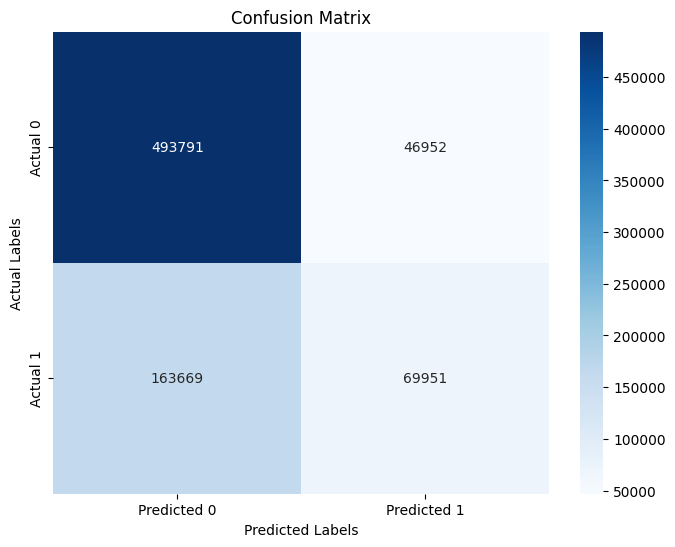

In [27]:
log_reg(X = X,
        y = y,
        n_features = 7,
        sorted_features = sorted_features)

In [28]:
def svm(X, y, sorted_features, n_features, epochs=10, batch_size=50000, test_size=0.2, random_state=42):
    """
    Trains an SGDClassifier with hinge loss (SVM) using batching and computes evaluation metrics.

    Parameters:
        X (pd.DataFrame): Feature matrix.
        y (pd.Series or np.array): Target vector.
        sorted_features (pd.DataFrame): DataFrame with feature names and their importance scores.
        n_features (int): Number of top features to select.
        epochs (int): Number of epochs for training. Default is 10.
        batch_size (int): Batch size for partial_fit. Default is 50,000.
        test_size (float): Proportion of test data. Default is 0.2.
        random_state (int): Random state for reproducibility. Default is 42.

    Returns:
        None. Prints classification metrics and displays a confusion matrix.
    """
    # Select top n features based on Overall_Importance
    top_features = sorted_features.nlargest(n_features, 'Overall_Importance').Feature.to_list()
    print(f"Selected Top {n_features} Features: {top_features}")

    # Filter the dataset to use only the selected features
    X_6 = X[top_features]

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_6, y, test_size=test_size, random_state=random_state)

    # Compute class weights for imbalanced data
    classes = np.unique(y_train)
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
    class_weight_dict = dict(zip(classes, class_weights))

    # Initialize SGDClassifier with hinge loss for SVM
    model = SGDClassifier(loss='hinge',  # hinge loss for SVM
                          penalty='elasticnet',
                          tol=1e-3,
                          learning_rate='optimal',
                          eta0=0.01,
                          random_state=random_state)

    # Training with batching
    for epoch in tqdm(range(epochs), desc="Epoch Progress", unit="epoch"):
        for i in tqdm(range(0, len(X_train), batch_size),
                      desc="Batch Progress",
                      unit="batch",
                      leave=False):
            X_batch = X_train.iloc[i:i + batch_size]
            y_batch = y_train.iloc[i:i + batch_size]

            model.partial_fit(X_batch,
                              y_batch,
                              classes=classes,
                              sample_weight=[class_weight_dict[cls] for cls in y_batch])

    # Make predictions
    y_pred = model.predict(X_test)

    # Classification report
    print("\nClassification Report")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Metrics using standard libraries
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)  # Sensitivity
    f1 = f1_score(y_test, y_pred)

    # Metrics calculated using formulas
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Print metrics
    print("\nEvaluation Metrics:")
    print(f"Accuracy    : {accuracy:.4f}")
    print(f"Precision   : {precision:.4f}")
    print(f"Recall/Sensitivity: {recall:.4f}")
    print(f"Specificity : {specificity:.4f}")
    print(f"F1 Score    : {f1:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel("Predicted Labels")
    plt.ylabel("Actual Labels")
    plt.title("Confusion Matrix")
    plt.show()


Selected Top 7 Features: ['Lead', 'Zinc', 'Copper', 'Total Dissolved Solids', 'Conductivity', 'Air Temperature', 'Chlorine']


Epoch Progress: 100%|██████████| 10/10 [00:24<00:00,  2.45s/epoch]



Classification Report
              precision    recall  f1-score   support

           0       0.72      0.97      0.83    540743
           1       0.70      0.14      0.23    233620

    accuracy                           0.72    774363
   macro avg       0.71      0.56      0.53    774363
weighted avg       0.72      0.72      0.65    774363


Evaluation Metrics:
Accuracy    : 0.7227
Precision   : 0.7007
Recall/Sensitivity: 0.1410
Specificity : 0.9740
F1 Score    : 0.2347


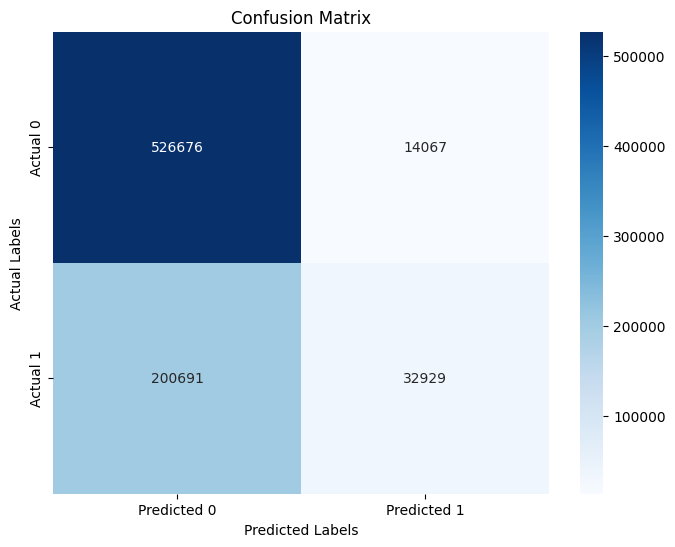

In [29]:
svm(X = X,
    y = y,
    n_features = 7,
    sorted_features = sorted_features)

In [30]:
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import RandomUnderSampler

def KNN(X, y, sorted_features, n_features, n_neighbors=5, test_size=0.2, random_state=42, metric='minkowski'):
    """
    Trains a K-Nearest Neighbors (KNN) model and computes evaluation metrics.

    Parameters:
        X (pd.DataFrame): Feature matrix.
        y (pd.Series or np.array): Target vector.
        sorted_features (pd.DataFrame): DataFrame with feature names and their importance scores.
        n_features (int): Number of top features to select.
        n_neighbors (int): Number of neighbors for KNN. Default is 5.
        test_size (float): Proportion of test data. Default is 0.2.
        random_state (int): Random state for reproducibility. Default is 42.
        metric (str): Distance metric for KNN. Default is 'minkowski'.

    Returns:
        None. Prints classification metrics and displays a confusion matrix.
    """
    # Select top n features based on Overall_Importance
    top_features = sorted_features.nlargest(n_features, 'Overall_Importance').Feature.to_list()
    print(f"Selected Top {n_features} Features: {top_features}")

    # Filter the dataset to use only the selected features
    X_6 = X[top_features]

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_6, y, test_size=test_size, random_state=random_state)

    # Perform random undersampling to handle class imbalance
    rus = RandomUnderSampler(random_state=random_state)
    X_train, y_train = rus.fit_resample(X_train, y_train)

    # Initialize KNeighborsClassifier
    model = KNeighborsClassifier(n_neighbors=n_neighbors,
                                  metric=metric,
                                  p=2,  # p=2 for Euclidean distance
                                  weights='distance')  # Weight by distance

    print('Starting model training...')
    model.fit(X_train, y_train)
    print('Model training complete.')

    # Make predictions
    print('starting with predictions.')
    y_pred = model.predict(X_test)
    print('completed predictions.')

    # Classification report
    print("\nClassification Report")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Metrics using standard libraries
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)  # Sensitivity
    f1 = f1_score(y_test, y_pred)

    # Metrics calculated using formulas
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Print metrics
    print("\nEvaluation Metrics:")
    print(f"Accuracy    : {accuracy:.4f}")
    print(f"Precision   : {precision:.4f}")
    print(f"Recall/Sensitivity: {recall:.4f}")
    print(f"Specificity : {specificity:.4f}")
    print(f"F1 Score    : {f1:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel("Predicted Labels")
    plt.ylabel("Actual Labels")
    plt.title("Confusion Matrix")
    plt.show()


Selected Top 7 Features: ['Lead', 'Zinc', 'Copper', 'Total Dissolved Solids', 'Conductivity', 'Air Temperature', 'Chlorine']
Starting model training...
Model training complete.
starting with predictions.
completed predictions.

Classification Report
              precision    recall  f1-score   support

           0       0.74      0.64      0.68    540743
           1       0.36      0.47      0.41    233620

    accuracy                           0.59    774363
   macro avg       0.55      0.55      0.54    774363
weighted avg       0.62      0.59      0.60    774363


Evaluation Metrics:
Accuracy    : 0.5858
Precision   : 0.3579
Recall/Sensitivity: 0.4699
Specificity : 0.6358
F1 Score    : 0.4063


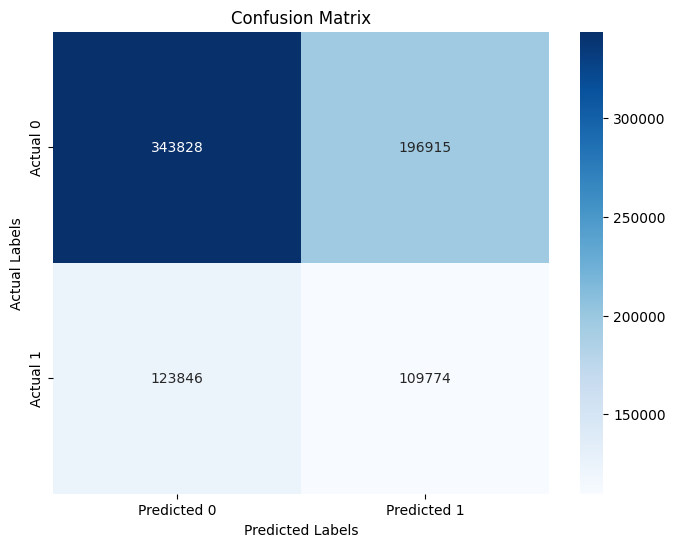

CPU times: user 40.3 s, sys: 741 ms, total: 41.1 s
Wall time: 41.2 s


In [31]:
%%time
KNN(X = X,
    y = y,
    n_features = 7,
    sorted_features = sorted_features,
    n_neighbors = 7,
    metric = 'euclidean')

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample

def random_forest(X, y, sorted_features, n_features, target_rows=300000,
                  n_estimators=100, max_depth=None, test_size=0.2, random_state=42):
    """
    Reduces dataset size, trains a Random Forest model, calculates evaluation metrics,
    and displays a confusion matrix.

    Parameters:
        X (pd.DataFrame): Feature matrix.
        y (pd.Series or np.array): Target vector.
        sorted_features (pd.DataFrame): DataFrame with feature names and their importance scores.
        n_features (int): Number of top features to select.
        target_rows (int): Target number of rows after reduction. Default is 100,000.
        n_estimators (int): Number of trees in the forest. Default is 100.
        max_depth (int or None): Maximum depth of the trees. Default is None.
        test_size (float): Proportion of test data. Default is 0.2.
        random_state (int): Random state for reproducibility. Default is 42.

    Returns:
        None. Prints classification metrics and displays a confusion matrix.
    """
    # Reduce the dataset to target_rows while maintaining class distribution
    data = X.copy()
    data['target'] = y
    data_resampled = resample(data,
                              replace=False,
                              n_samples=target_rows,
                              stratify=data['target'],
                              random_state=random_state)
    X = data_resampled.drop(columns=['target'])
    y = data_resampled['target']

    print(f"Dataset reduced to {target_rows} rows while maintaining class balance.")

    # Select top n features based on Overall_Importance
    top_features = sorted_features.nlargest(n_features, 'Overall_Importance').Feature.to_list()
    print(f"Selected Top {n_features} Features: {top_features}")

    # Filter the dataset to use only the selected features
    X_6 = X[top_features]

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_6, y, test_size=test_size, random_state=random_state)

    # Initialize Random Forest Classifier
    model = RandomForestClassifier(n_estimators=n_estimators,
                                    max_depth=max_depth,
                                    random_state=random_state,
                                    class_weight="balanced")  # Handle class imbalance

    # Train the model
    print("Training Random Forest model...")
    model.fit(X_train, y_train)
    print("Training complete!")

    # Make predictions
    y_pred = model.predict(X_test)

    # Classification report
    print("\nClassification Report")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Metrics using standard libraries
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)  # Sensitivity
    f1 = f1_score(y_test, y_pred)

    # Metrics calculated using formulas
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Print metrics
    print("\nEvaluation Metrics:")
    print(f"Accuracy    : {accuracy:.4f}")
    print(f"Precision   : {precision:.4f}")
    print(f"Recall/Sensitivity: {recall:.4f}")
    print(f"Specificity : {specificity:.4f}")
    print(f"F1 Score    : {f1:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel("Predicted Labels")
    plt.ylabel("Actual Labels")
    plt.title("Confusion Matrix")
    plt.show()


Dataset reduced to 300000 rows while maintaining class balance.
Selected Top 7 Features: ['Lead', 'Zinc', 'Copper', 'Total Dissolved Solids', 'Conductivity', 'Air Temperature', 'Chlorine']
Training Random Forest model...
Training complete!

Classification Report
              precision    recall  f1-score   support

           0       0.81      0.92      0.86     41869
           1       0.73      0.52      0.60     18131

    accuracy                           0.80     60000
   macro avg       0.77      0.72      0.73     60000
weighted avg       0.79      0.80      0.78     60000


Evaluation Metrics:
Accuracy    : 0.7953
Precision   : 0.7270
Recall/Sensitivity: 0.5166
Specificity : 0.9160
F1 Score    : 0.6040


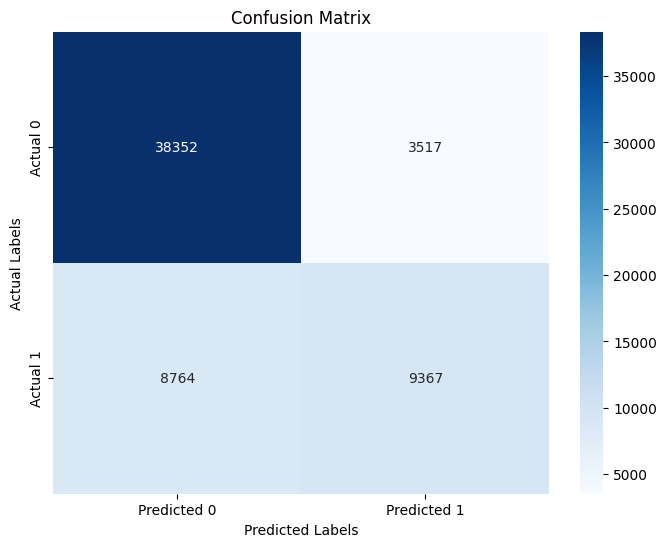

CPU times: user 2min 49s, sys: 540 ms, total: 2min 49s
Wall time: 2min 50s


In [33]:
%%time
random_forest(X = X,
              y = y,
              n_features = 7,
              sorted_features = sorted_features,
              n_estimators = 200,
              max_depth = 10)

In [34]:
import xgboost as xgb
from sklearn.utils import resample

def xg(X,
       y,
       sorted_features, n_features,
       target_rows=200000,
       n_estimators=100,
       early_stopping_rounds=10,
       test_size=0.2,
       random_state=42):
    """
    Reduces dataset size, trains an XGBoost model with early stopping, calculates evaluation metrics,
    and displays a confusion matrix.

    Parameters:
        X (pd.DataFrame): Feature matrix.
        y (pd.Series or np.array): Target vector.
        sorted_features (pd.DataFrame): DataFrame with feature names and their importance scores.
        n_features (int): Number of top features to select.
        target_rows (int): Target number of rows after reduction. Default is 200,000.
        n_estimators (int): Maximum number of trees in the model. Default is 100.
        early_stopping_rounds (int): Number of rounds to wait for improvement before stopping early. Default is 10.
        test_size (float): Proportion of test data. Default is 0.2.
        random_state (int): Random state for reproducibility. Default is 42.

    Returns:
        None. Prints classification metrics and displays a confusion matrix.
    """
    # Reduce the dataset to target_rows while maintaining class distribution
    data = X.copy()
    data['target'] = y
    data_resampled = resample(data,
                              replace=False,
                              n_samples=target_rows,
                              stratify=data['target'],
                              random_state=random_state)
    X = data_resampled.drop(columns=['target'])
    y = data_resampled['target']

    # Select top n features based on Overall_Importance
    top_features = sorted_features.nlargest(n_features, 'Overall_Importance').Feature.to_list()
    print(f"Selected Top {n_features} Features: {top_features}")

    # Filter the dataset to use only the selected features
    X = X[top_features]

    # Split data into training, validation, and testing sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size, random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_state)

    # Create the DMatrix objects for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Specify XGBoost parameters
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': 6,
        'eta': 0.1,
        'random_state': random_state
    }

    # Train the model with early stopping
    evals = [(dtrain, 'train'), (dval, 'eval')]
    model = xgb.train(params,
                      dtrain,
                      num_boost_round=n_estimators,
                      evals=evals,
                      early_stopping_rounds=early_stopping_rounds,
                      verbose_eval=True)

    print("\nTraining complete! Evaluating on the test set...")

    # Predict on the test set
    y_test_pred_prob = model.predict(dtest)
    y_test_pred = (y_test_pred_prob > 0.5).astype(int)

    # Classification report
    print("\nClassification Report")
    print(classification_report(y_test, y_test_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    tn, fp, fn, tp = cm.ravel()

    # Metrics using standard libraries
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)  # Sensitivity
    f1 = f1_score(y_test, y_test_pred)

    # Metrics calculated using formulas
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Print metrics
    print("\nEvaluation Metrics:")
    print(f"Accuracy    : {accuracy:.4f}")
    print(f"Precision   : {precision:.4f}")
    print(f"Recall/Sensitivity: {recall:.4f}")
    print(f"Specificity : {specificity:.4f}")
    print(f"F1 Score    : {f1:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel("Predicted Labels")
    plt.ylabel("Actual Labels")
    plt.title("Confusion Matrix")
    plt.show()


Selected Top 7 Features: ['Lead', 'Zinc', 'Copper', 'Total Dissolved Solids', 'Conductivity', 'Air Temperature', 'Chlorine']
[0]	train-logloss:0.59137	eval-logloss:0.59241
[1]	train-logloss:0.57500	eval-logloss:0.57608
[2]	train-logloss:0.56208	eval-logloss:0.56321
[3]	train-logloss:0.55174	eval-logloss:0.55292
[4]	train-logloss:0.54339	eval-logloss:0.54463
[5]	train-logloss:0.53660	eval-logloss:0.53789
[6]	train-logloss:0.53108	eval-logloss:0.53242
[7]	train-logloss:0.52656	eval-logloss:0.52794
[8]	train-logloss:0.52285	eval-logloss:0.52429
[9]	train-logloss:0.51980	eval-logloss:0.52129
[10]	train-logloss:0.51729	eval-logloss:0.51883
[11]	train-logloss:0.51523	eval-logloss:0.51681
[12]	train-logloss:0.51352	eval-logloss:0.51516
[13]	train-logloss:0.51213	eval-logloss:0.51380
[14]	train-logloss:0.51097	eval-logloss:0.51268
[15]	train-logloss:0.51002	eval-logloss:0.51177
[16]	train-logloss:0.50923	eval-logloss:0.51103
[17]	train-logloss:0.50857	eval-logloss:0.51042
[18]	train-logloss:0.

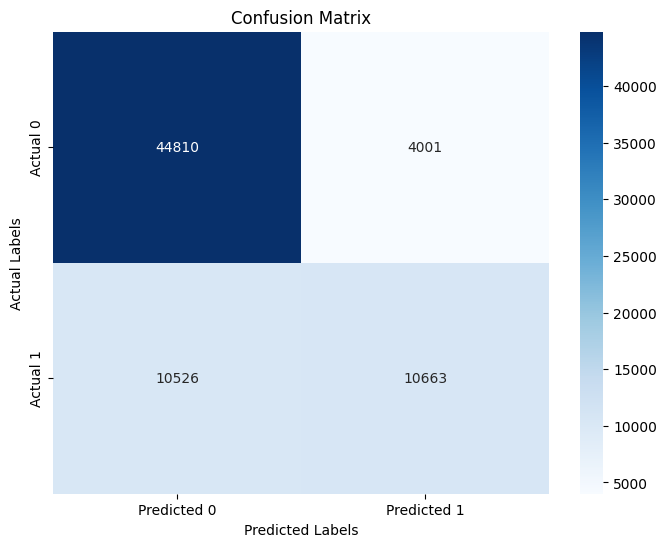

CPU times: user 11.8 s, sys: 324 ms, total: 12.1 s
Wall time: 9.34 s


In [35]:
%%time
xg(X=X,
   y=y,
   sorted_features = sorted_features,
   n_features = 7,
   target_rows = 700000,
   n_estimators = 100,
   early_stopping_rounds = 10)